**DEMO FOR THE CASE OF TRANSFER LEARNING, PRETRAINED ON IMAGENET, USING RESNET-18**


### Import libraries

In [ ]:
from PIL import Image
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from skimage import io
from skimage import color
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
from skimage.io import imread
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pydicom as dicom
import matplotlib
font={'weight':'bold', 'size':11}
matplotlib.rc('font', **font)

### From Dicom to PNG

In [ ]:
df= pd.read_csv('train.csv')
df.columns=["ID", "Labels"]

In [ ]:
le = LabelEncoder()
le.fit(df["Labels"])
le.classes_
df["Labels"]=le.transform(df["Labels"])

In [ ]:
#Atypical=0, Indeterminate= 1, Negative=2, Typical=3
for i in os.listdir('RSNACOVID/train/'):
    for j in os.listdir('RSNACOVID/train/'+i):
        for k in os.listdir('RSNACOVID/train/'+i+'/'+j):
            im= dicom.dcmread('RSNACOVID/train/'+i+'/'+j+'/'+k)
            print('RSNACOVID/train/'+i+'/'+j+'/'+k)
            im.PhotometricInterpretation = 'YBR_FULL'
            im=im.pixel_array.astype(float)
            rescaled_image=(np.maximum(im,0)/im.max())*255
            final_image=np.uint8(rescaled_image)
            final_image= Image.fromarray(final_image)
            if int(df.loc[df['ID']==i+'_study']['Labels'])==2:
                final_image.save('/home/shahad.hardan/Downloads/ML Pro Dataset/Negative/'+i+'.png')
            elif int(df.loc[df['ID']==i+'_study']['Labels'])==0:
                final_image.save('/home/shahad.hardan/Downloads/ML Pro Dataset/Atypical Appearance/'+i+'.png')
            elif int(df.loc[df['ID']==i+'_study']['Labels'])==1:
                final_image.save('/home/shahad.hardan/Downloads/ML Pro Dataset/Indeterminate/'+i+'.png')
            elif int(df.loc[df['ID']==i+'_study']['Labels'])==3:
                final_image.save('/home/shahad.hardan/Downloads/ML Pro Dataset/Typical Appearance/'+i+'.png')
            

###  Resize and transform to RGB

In [ ]:
#Resize image Atypical Appearance 
for i in os.listdir('/home/shahad.hardan/Downloads/ML Pro Dataset/Atypical Appearance/'):
    im = Image.open('/home/shahad.hardan/Downloads/ML Pro Dataset/Atypical Appearance/'+'/'+i)
    new_im= im.resize((224,224))
    new_im.save('/home/shahad.hardan/Downloads/COVID_resized 224/Atypical Appearance/'+i)

In [ ]:
#Resize image Indeterminate 
for i in os.listdir('/home/shahad.hardan/Downloads/ML Pro Dataset/Indeterminate/'):
    im = Image.open('/home/shahad.hardan/Downloads/ML Pro Dataset/Indeterminate/'+i)
    new_im= im.resize((224,224))
    new_im.save('/home/shahad.hardan/Downloads/COVID_resized 224/Indeterminate/'+i)
    

In [ ]:
#Resize image Negative
for i in os.listdir('/home/shahad.hardan/Downloads/ML Pro Dataset/Negative/'):
    im = Image.open('/home/shahad.hardan/Downloads/ML Pro Dataset/Negative/'+i)
    new_im= im.resize((224,224))
    new_im.save('/home/shahad.hardan/Downloads/COVID_resized 224/Negative /'+i)
    

In [ ]:
# # Resize image Typical Appearance

for i in os.listdir('/home/shahad.hardan/Downloads/ML Pro Dataset/Typical Appearance/'):
    im = Image.open('/home/shahad.hardan/Downloads/ML Pro Dataset/Typical Appearance/'+i)
    new_im= im.resize((224,224))
    new_im.save('/home/shahad.hardan/Downloads/COVID_resized 224/Typical Appearance/'+i)

In [ ]:
#Transform gray scale atypical images to RGB 
path_org= '/home/shahad.hardan/Downloads/COVID_resized 224/Atypical Appearance/'
for i in os.listdir(path_org):
    image=io.imread(path_org+i)
    path='/home/shahad.hardan/Downloads/COVID_RGB/Atypical/'
    if len(image.shape)==3:
        path = path + (i)
        io.imsave(path, image)
    elif len(image.shape)==2:
        image=color.gray2rgb(image)
        path = path + (i)
        io.imsave(path, image)

In [ ]:
#Transform gray scale typical images to RGB 
path_org= '/home/shahad.hardan/Downloads/COVID_resized 224/Typical Appearance/'
for i in os.listdir(path_org):
    image=io.imread(path_org+i)
    path='/home/shahad.hardan/Downloads/COVID_RGB/Typical/'
    if len(image.shape)==3:
        path = path + (i)
        io.imsave(path, image)
    elif len(image.shape)==2:
        image=color.gray2rgb(image)
        path = path + (i)
        io.imsave(path, image)

In [ ]:
#Transform gray scale negative images to RGB 
path_org= '/home/shahad.hardan/Downloads/COVID_resized 224/Negative /'
for i in os.listdir(path_org):
    image=io.imread(path_org+i)
    path='/home/shahad.hardan/Downloads/COVID_RGB/Negative/'
    if len(image.shape)==3:
        path = path + (i)
        io.imsave(path, image)
    elif len(image.shape)==2:
        image=color.gray2rgb(image)
        path = path + (i)
        io.imsave(path, image)

In [ ]:

#Transform gray scale indeterminate images to RGB 
path_org= '/home/shahad.hardan/Downloads/COVID_resized 224/Indeterminate/'
for i in os.listdir(path_org):
    image=io.imread(path_org+i)
    path='/home/shahad.hardan/Downloads/COVID_RGB/Indeterminate/'
    if len(image.shape)==3:
        path = path + (i)
        io.imsave(path, image)
    elif len(image.shape)==2:
        image=color.gray2rgb(image)
        path = path + (i)
        io.imsave(path, image)

### Dataset Class

In [ ]:
class CXRDataSet (Dataset):
    
    def __init__(self,dataset,band,transform=None):
        self.dataset= self.checkchannels(dataset, band)
        self.transform= transform
        
    def checkchannels(self, dataset, band):
        
        if band =='RGB':
            datasetRGB=[]
            for index in range(len(dataset)):
                if Image.open(dataset[index][0]).getbands()==('R','G','B'):
                    datasetRGB.append(dataset[index])
            return datasetRGB
        elif band =='L':
            datasetG=[]
            for index in range(len(dataset)):
                if Image.open(dataset[index][0]).getbands()==('L',):
                    datasetG.append(dataset[index])
            return datasetG
    
    def croppingframe(self, index): # Custom transform
        image= io.imread(self.dataset[index][0])
        nonzero_pixels = image[np.nonzero(image)]
        if nonzero_pixels.shape == (0,):
            return image
        min=np.array(np.nonzero(image)).min(axis=1)
        max=np.array(np.nonzero(image)).max(axis=1)
        return image[min[0]:max[0]+1,min[1]:max[1]+1]
    
    def __getitem__(self,index): # allows us to index our instance
        
        image= self.croppingframe(index)
        image= Image.fromarray(image)
        y_label=torch.tensor(self.dataset[index][1])
        if self.transform:
            return self.transform(image), y_label
        
        return image,y_label 
    
    def __len__(self):
        return len(self.dataset)
    

### Load the paths of the images

In [ ]:
path_to_rgbdata='COVID_RGB'
data= ImageFolder(path_to_rgbdata)

#print(data) 
print('Total number of datapoints:', len(data.imgs))
# shows the number of datapoints and root location
print('---------------------------')
# list of tuples, each of which contains the image path and its label 

print("Dataset classes:", data.classes) 
# the name of the classes [Normal , covid, ..]

Total number of datapoints: 6053
---------------------------
Dataset classes: ['Atypical', 'Indeterminate', 'Negative', 'Typical']


### Histogram of classes

[474, 1049, 1676, 2854] ['Atypical', 'Indeterminate', 'Negative', 'Typical']


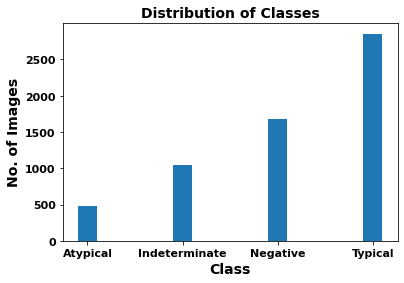

In [ ]:
# Show imbalance in dataset
counter= [ data.targets.count(l) for l in set(data.targets)]
labels = data.classes
print(counter,labels)
plt.bar(labels,counter, width=0.2)
plt.xlabel("Class", fontsize=14, fontweight='bold')
plt.ylabel("No. of Images", fontsize=14, fontweight='bold')
plt.title("Distribution of Classes", fontsize=14, fontweight='bold')
plt.show()

### Splitting the data

In [ ]:
# Split dataset into train test sets:
trainData,testData,trainLabel,testLabel=train_test_split(data.imgs,data.targets,
                                                        test_size=0.1,
                                                         random_state=0, stratify=data.targets)

"""
Setting the random_state is desirable for reproducibility.

This stratify parameter makes a split so that the proportion of values
in the sample produced will be the same as the proportion of values provided
to parameter stratify.

For example, if variable y is a binary categorical variable with 
values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y
will make sure that your random split has 25% of 0's and 75% of 1's.


""";

#print(type(trainData[0][1]))
# print(testData) # Notice it contains the labels as well!
#we'll not use trainLabel, testLabel

### Evaluate mean & std of the training set images

In [ ]:
# Evaluate mean and std of images:
# mean and std are dependent on image size.
Data_transforms= transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor()])

CXR_dataset= CXRDataSet(trainData,'RGB',
                        transform=Data_transforms)

CXR_loader= torch.utils.data.DataLoader(CXR_dataset,
                                        batch_size=32,num_workers=4 ,shuffle= False)

def get_mean_and_std(loader):
    mean=0.
    std=0.
    Total_images_count= 0.
    for images,_ in loader:
        Total_images_count += images.size(0)
        # or you can use images.shape[0]
        #print(images.shape) B xC X H X W
        images= images.view(images.size(0), images.size(1),-1)
        # print(images.shape) B x C x (H*W)
        mean+= images.mean(2).sum(0)
        # find the mean of each channel
        #in all images of the batch, axis=2
        # sum the means of corresponding 
        # channels of the batch images, axis=0
        std+= images.std(2).sum(0)
    
    mean/= Total_images_count
    std/=Total_images_count
    
    return mean, std


mean, std = get_mean_and_std(CXR_loader)

In [ ]:
mean,std

(tensor([0.5388, 0.5388, 0.5388]), tensor([0.1938, 0.1938, 0.1938]))

### Image Transformations and loading the images

In [ ]:
train_data_transforms= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])


test_data_transforms= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])



train_set= CXRDataSet(trainData,'RGB',
                        transform=train_data_transforms)
test_set=CXRDataSet(testData,'RGB',
                        transform=test_data_transforms) 


print("Size of train dataset: ", len(train_set))
print("Size of test dataset: ",len(test_set))


Size of train dataset:  5447
Size of test dataset:  606


In [ ]:
batch_size = 16 

train_loader= DataLoader(dataset= train_set,
                         batch_size= batch_size,
                         shuffle =True,
                         num_workers = 8)
test_loader= DataLoader(dataset= test_set,
                        batch_size= batch_size,
                        shuffle =False, 
                        num_workers = 8)
"""
DataLoader returns a Python iterable over 
a dataset, with support for automatic batching
and more other features

Parameters: 
dataset (Dataset) – dataset from which to load the data.

batch_size (int, optional) – how many samples per batch to
load (default: 1).

shuffle (bool, optional) – set to True to have the data 
reshuffled at every epoch (default: False).

""";

### Show transformed Images

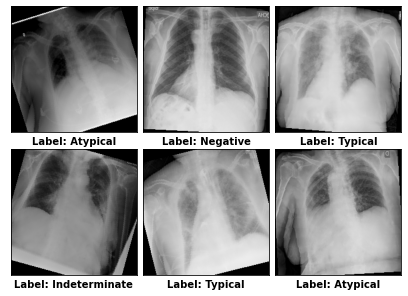

In [ ]:
def show_transformed_images(dataset):
    
    loader= torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch= next(iter(loader))
    images, labels= batch
    #print(images.shape) # BxCxWxH
    images = images.numpy().transpose((0,2, 3, 1)) 
    # convert the images from torch to numpy and transpose
    #print(images.shape)# BxWxHxC
    mean_arr = np.array(mean)
    std_arr = np.array(std)
    images = std_arr * images + mean_arr
    # When we normalize our data, it gets shifted, such that 
    # its mean becomes 0 and std. dev. of 1 i.e. the data will have negative portion. 
    images = np.clip(images, 0, 1)
    fig, axes = plt.subplots(2, 3, figsize=(7, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_xlabel('Label: {}'.format(data.classes[labels[i]]),fontsize=10, fontweight='bold' )
        


    """
    numpy.clip() function is used to Clip (limit) the values in an array.

    Given an interval, values outside the interval are clipped to the interval edges.
    For example, if an interval of [0, 1] is specified, values smaller than 0 become 0,
    and values larger than 1 become 1.
    
    Reference : https://www.geeksforgeeks.org/numpy-clip-in-python/
    """;
show_transformed_images(train_set)

## Training and Testing phases

##### Set device: 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

##### Train neural network function

In [ ]:

def train_nn (model,train_loader,test_loader,loss_func_train,loss_func_test, optimizer,epochs,modelname):
    best_val_acc=0
    train_loss =[]
    test_loss=[]
    checkpoint_path=f'{modelname}.pth'

    for epoch in range(epochs):
        
        print(f'Epoch number {epoch}')
        # set the model to training mode:
        model.train()
        running_loss=0.0
        running_correct= 0.0
        total= 0

        
        for batch in train_loader:
            images,labels= batch
            images=images.to(device)
            labels= labels.to(device)
            total+= labels.size(0) # get integer value
            
            optimizer.zero_grad()
            
            outputs= model(images)
            _,predicted = torch.max(outputs.data,1)
            
            
            loss= loss_func_train(outputs, labels)
            # label is a single value, output is a vector
            loss.backward()
            
            optimizer.step()
            
            running_loss+= loss.item() * labels.size(0)
            running_correct+= (labels==predicted).sum().item()
        
        epoch_loss= running_loss/total
        epoch_acc= (running_correct/total)*100
        
        train_loss.append(epoch_loss)
        print(f'Train: {epoch_acc}% of the images classified correctly. Epoch loss= {epoch_loss}')
    
        test_labels, pred_cls, pred_proba,t_loss, epoch_val_acc= test_model(model,test_loader,loss_func_test)
        
        test_loss.append(t_loss)

        if epoch_val_acc > best_val_acc:
              best_val_acc = epoch_val_acc
            #  save_checkpoint(model, optimizer,epoch,best_val_acc, modelname)
              torch.save(model.state_dict(), checkpoint_path)

    
    
    print('Done with training and testing..')
    return model,test_labels, pred_cls, pred_proba, train_loss, test_loss
        

#####  Test model function

In [ ]:
def test_model(model,test_loader,loss_func_test):
    
    model.eval()
    predicted_correctly=0
    total=0
    test_running_loss=0
    t_loss= 0.0
    # Variables defined for post-training analysis
    test_labels=[]
    pred_cls=[]
    pred_proba=[]
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images=images.to(device)
            labels= labels.to(device)
            total += labels.size(0) # get integer value
            
            test_labels.append(labels)
            outputs= model(images)
            pred_proba.append(outputs)
            
            loss = loss_func_test(outputs, labels)
            _, predicted = torch.max(outputs,1)
            
            
            pred_cls.append(predicted)
            
            predicted_correctly+= (predicted==labels).sum().item()
            test_running_loss+= loss.item() * labels.size(0)
            
    
    test_acc= (predicted_correctly/total)*100
    t_loss = test_running_loss/total
    
    
    print(f'Test: {test_acc}% of the images are classified correctly. Epoch loss = {t_loss}')
    
    return test_labels, pred_cls, pred_proba, t_loss, test_acc
    

#####  Computing class weights function

In [ ]:
from sklearn.utils import class_weight

def calculate_cls_weight(trainData):
    
    labels=[]
    
    for _,label in trainData:
        labels.append(label)
    
    class_weights=class_weight.compute_class_weight('balanced',classes= np.unique(labels),y= np.array(labels))
    class_weights=torch.tensor(class_weights,dtype=torch.float, device= device)
    
    print('class weights:',class_weights)
    return class_weights

## Analysis

In [ ]:
def eval_best_model (model, model_path,n_classes ,loss_func_test,device, band= 'RGB'):
    
    if model == 'resnet18':
        best_model = models.resnet18()
        input_ftrs = best_model.fc.in_features
        best_model.fc= nn.Linear(input_ftrs, n_classes)
        if band =='L':
            best_model.conv1=nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3,bias=False)
            
    elif model == 'densenet121':
        best_model = models.densenet121()
        input_ftrs = best_model.classifier.in_features
        best_model.classifier= nn.Linear(input_ftrs, n_classes)
        if band=='L':
            best_model.features.conv0=nn.Conv2d(1, 64, kernel_size=7, stride=2,padding=3, bias=False)
            
    ckpt=torch.load(model_path)
    best_model.load_state_dict(ckpt)
    best_model= best_model.to(device)
    test_labels, pred_cls, pred_proba, t_loss, test_acc =test_model(best_model,test_loader,loss_func_test)
    return  test_labels, pred_cls, pred_proba, t_loss, test_acc

In [ ]:
def conf_mtrx (test_labels,pred_cls):
    
    test_labels= torch.cat(test_labels).to('cpu')# cat= concatenate
    pred_cls= torch.cat(pred_cls).to('cpu')
    
    conf_matrx = confusion_matrix(test_labels,pred_cls)
    
    class_names = data.classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(conf_matrx), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    #You can change the position of the title by providing 
    # a value for the y parameter 
    plt.title('Confusion matrix [0:Atypical, 1:Indeterminate, 2:Negative, 3:Typical]', y=1.2,fontsize=14, fontweight='bold')
    plt.ylabel('Actual Label', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label',fontsize=14, fontweight='bold') 

In [ ]:
def ROC_plot_AUC_score (test_labels,pred_proba,n_classes):
    test_labels= torch.cat(test_labels).to('cpu')# cat= concatenate
    pred_proba= torch.cat(pred_proba, dim=0).to('cpu')
    
    soft_func = nn.Softmax(dim=1)
    pred_proba= soft_func(pred_proba)

    fpr = {} # False postive rate x-axis
    tpr = {} # True positive rate y-axis
    thresh ={}
    auc_scores = []
    one_vs_all_labels=[]
    
    for i in range(n_classes):
        one_vs_all_labels.append((test_labels== i).numpy().astype('int'))   
    
    
    for i in range(n_classes):    
        fpr[i], tpr[i], thresh[i] = roc_curve(one_vs_all_labels[i], pred_proba[:,i], pos_label=1)
        auc_scores.append(roc_auc_score(one_vs_all_labels[i], pred_proba[:,i]))
    

    for i in range(n_classes):

        plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {data.classes[i]} vs Rest')  

    plt.title('Multiclass ROC Curve',fontsize=14, fontweight='bold')
    plt.xlabel('False Positive Rate',fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate',fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    
# Display AUC scores
    
    for i in range(n_classes):
        print(f'AUC score of Class {data.classes[i]} vs Rest ===>',auc_scores[i] )


In [ ]:
target_names = data.classes 

def evaluate_metrics (test_labels,pred_cls, target_names):

    test_labels= torch.cat(test_labels).to('cpu')# cat= concatenate
    pred_cls= torch.cat(pred_cls).to('cpu')
    
    print(classification_report(test_labels,pred_cls, target_names=target_names))

In [ ]:
def plot_learning_curve(x_epoch, train_loss, test_loss):
    
    
    print('test_loss:',test_loss)
    x_epoch= np.arange(x_epoch)
    plt.plot(x_epoch, train_loss, linestyle='--', label='Train loss')
    plt.plot(x_epoch, test_loss, linestyle='--', label='Test loss')

    
    plt.title('Learning Curve- loss against epochs plot',fontsize=14, fontweight='bold')
    plt.xlabel('Epochs', fontsize=14, fontweight='bold')
    plt.ylabel('Loss',fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.show()
    

## Transfer Learning

##### 1 Pretrained with ImageNet, Finetuned with CXR dataset. Model: resnet18

In [ ]:
seed = 1997
torch.cuda.manual_seed_all(seed)

In [ ]:
resnet18_model= models.resnet18(pretrained=True)  
input_ftrs= resnet18_model.fc.in_features
num_classes= 4
resnet18_model.fc= nn.Linear(input_ftrs, num_classes)
resnet18_model= resnet18_model.to (device)

loss_func_test= nn.CrossEntropyLoss()

loss_func_train= nn.CrossEntropyLoss(weight= calculate_cls_weight(trainData))


optimizer = optim.AdamW(resnet18_model.parameters(), lr=0.001)

modelname='resnet18_preimagenet_ftcxr'
epochs= 25
model,_, _, _, train_loss, test_loss=train_nn(resnet18_model,
                                              train_loader,test_loader,
                                              loss_func_train,loss_func_test, optimizer,epochs, modelname)

class weights: tensor([3.1891, 1.4425, 0.9030, 0.5303], device='cuda:0')
Epoch number 0
Train: 40.389205067009364% of the images classified correctly. Epoch loss= 1.394714739840469
Test: 27.22772277227723% of the images are classified correctly. Epoch loss = 1.8403727465336865
Epoch number 1
Train: 45.89682393978337% of the images classified correctly. Epoch loss= 1.345374055952244
Test: 53.46534653465347% of the images are classified correctly. Epoch loss = 1.1355920853001056
Epoch number 2
Train: 47.60418579034331% of the images classified correctly. Epoch loss= 1.293935408324348
Test: 34.98349834983499% of the images are classified correctly. Epoch loss = 1.3547494242293607
Epoch number 3
Train: 50.17440793097118% of the images classified correctly. Epoch loss= 1.263968529735374
Test: 50.165016501650165% of the images are classified correctly. Epoch loss = 1.1929136699575795
Epoch number 4
Train: 51.845052322379296% of the images classified correctly. Epoch loss= 1.2590644453038902


In [ ]:
## Evaluate based on best model 


test_labels, pred_cls, pred_proba, _, _ =eval_best_model ('resnet18', 'resnet18_preimagenet_ftcxr.pth',
                                                          num_classes ,loss_func_test,device)

Test: 61.88118811881188% of the images are classified correctly. Epoch loss = 1.0144223848191818


##### Confusion Matrix

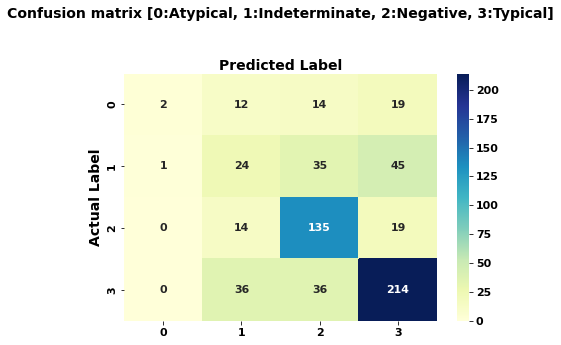

In [ ]:
conf_mtrx (test_labels,pred_cls)

#### Precision, Recall, & F1 score

In [ ]:
"""main"""
evaluate_metrics (test_labels,pred_cls, target_names)

               precision    recall  f1-score   support

     Atypical       0.67      0.04      0.08        47
Indeterminate       0.28      0.23      0.25       105
     Negative       0.61      0.80      0.70       168
      Typical       0.72      0.75      0.73       286

     accuracy                           0.62       606
    macro avg       0.57      0.46      0.44       606
 weighted avg       0.61      0.62      0.59       606



#### AUC- ROC

AUC score of Class Atypical vs Rest ===> 0.6761694515281849
AUC score of Class Indeterminate vs Rest ===> 0.6550708107594335
AUC score of Class Negative vs Rest ===> 0.8773374646662317
AUC score of Class Typical vs Rest ===> 0.8262674825174825


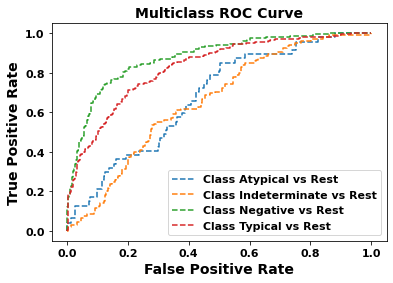

In [ ]:
ROC_plot_AUC_score (test_labels,pred_proba,len(data.classes))

#### Learning Curve

test_loss: [1.8403727465336865, 1.1355920853001056, 1.3547494242293607, 1.1929136699575795, 1.1773378553957041, 1.1204020170488767, 1.2354716774654073, 1.2271187624128739, 1.0624218579172695, 1.0144223848191818, 1.0788806535229825, 1.0800989209228615, 1.0589621110324419, 1.1081082352710636, 1.0081675430335622, 1.0524783787554246, 1.0673946091050754, 1.0407731576327837, 1.0899014626399126, 1.0202707327631835, 0.9972129879218123, 1.0617087564059215, 1.0846938658075365, 1.0894910451209192, 1.023003620283045]


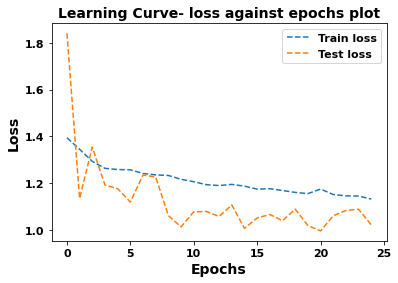

In [ ]:
x_epoch = 25
plot_learning_curve(x_epoch, train_loss, test_loss)